# Classification

In this notebook we demonstrate how to perform inference for Gaussian process models with non-Gaussian likelihoods via maximum a posteriori (MAP) and Markov chain Monte Carlo (MCMC). We focus on a classification task here and use [BlackJax](https://github.com/blackjax-devs/blackjax/) for sampling.

In [1]:
import blackjax
import distrax as dx
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import matplotlib.pyplot as plt
import optax as ox
from jax.config import config
from jaxtyping import Array, Float
from jaxutils import Dataset
import jaxkern as jk
import jax

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
I = jnp.eye
key = jr.PRNGKey(123)

## Dataset

With the necessary modules imported, we simulate a dataset $\mathcal{D} = (, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{100}$ with inputs $\boldsymbol{x}$ sampled uniformly on $(-1., 1)$ and corresponding binary outputs

$$\boldsymbol{y} = 0.5 * \text{sign}(\cos(2 *  + \boldsymbol{\epsilon})) + 0.5, \quad \boldsymbol{\epsilon} \sim \mathcal{N} \left(\textbf{0}, \textbf{I} * (0.05)^{2} \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs for later.

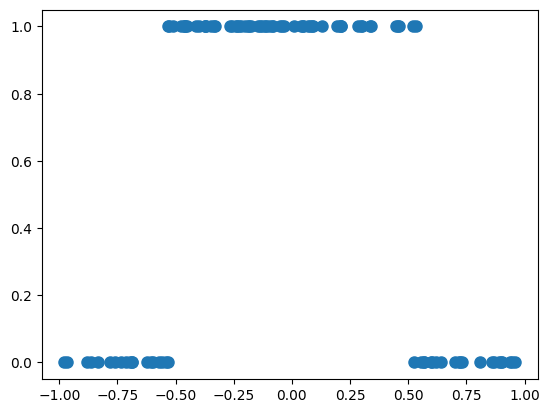

In [2]:
x = jnp.sort(jr.uniform(key, shape=(100, 1), minval=-1.0, maxval=1.0), axis=0)
y = 0.5 * jnp.sign(jnp.cos(3 * x + jr.normal(key, shape=x.shape) * 0.05)) + 0.5

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-1.0, 1.0, 500).reshape(-1, 1)
plt.plot(x, y, "o", markersize=8)

## MAP inference

We begin by defining a Gaussian process prior with a radial basis function (RBF) kernel, chosen for the purpose of exposition. Since our observations are binary, we choose a Bernoulli likelihood with a probit link function.

In [3]:
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)
likelihood = gpx.Bernoulli(num_datapoints=D.n)

We construct the posterior through the product of our prior and likelihood.

In [4]:
posterior = prior * likelihood
print(type(posterior))

<class 'gpjax.gps.NonConjugatePosterior'>


Whilst the latent function is Gaussian, the posterior distribution is non-Gaussian since our generative model first samples the latent GP and propagates these samples through the likelihood function's inverse link function. This step prevents us from being able to analytically integrate the latent function's values out of our posterior, and we must instead adopt alternative inference techniques. We begin with maximum a posteriori (MAP) estimation, a fast inference procedure to obtain point estimates for the latent function and the kernel's hyperparameters by maximising the marginal log-likelihood.

To begin we obtain an initial parameter state through the `initialise` callable (see the [regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html)). We can obtain a MAP estimate by optimising the marginal log-likelihood with Optax's optimisers.

In [5]:
parameter_state = gpx.initialise(posterior)
negative_mll = jax.jit(posterior.marginal_log_likelihood(D, negative=True))

optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=1000,
)

map_estimate, training_history = inference_state.unpack()

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_3983/4266840888.py:1: UserWarning: No PRNGKey specified. Defaulting to seed 123.
  parameter_state = gpx.initialise(posterior)


  0%|          | 0/1000 [00:00<?, ?it/s]

From which we can make predictions at novel inputs, as illustrated below.

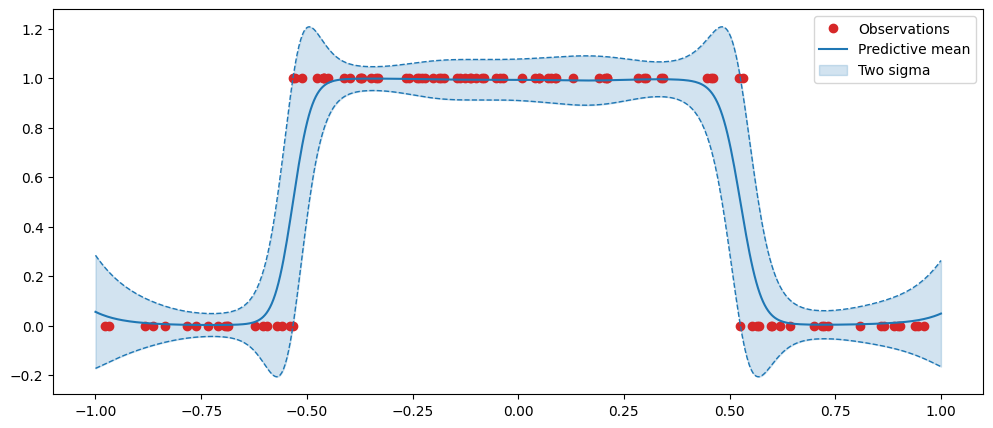

In [6]:
map_latent_dist = posterior(map_estimate, D)(xtest)

predictive_dist = likelihood(map_estimate, map_latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.legend()

Here we projected the map estimates $\hat{\boldsymbol{f}}$ for the function values $\boldsymbol{f}$ at the data points $\boldsymbol{x}$ to get predictions over the whole domain,

\begin{align}
p(f(\cdot)| \mathcal{D})  \approx q_{map}(f(\cdot)) := \int p(f(\cdot)| \boldsymbol{f}) \delta(\boldsymbol{f} - \hat{\boldsymbol{f}}) d \boldsymbol{f} = \mathcal{N}(\mathbf{K}_{\boldsymbol{(\cdot)x}}  \mathbf{K}_{\boldsymbol{xx}}^{-1} \hat{\boldsymbol{f}},  \mathbf{K}_{\boldsymbol{(\cdot, \cdot)}} - \mathbf{K}_{\boldsymbol{(\cdot)\boldsymbol{x}}} \mathbf{K}_{\boldsymbol{xx}}^{-1} \mathbf{K}_{\boldsymbol{\boldsymbol{x}(\cdot)}}).
\end{align}

However, as a point estimate, MAP estimation is severely limited for uncertainty quantification, providing only a single piece of information about the posterior.

## Laplace approximation
The Laplace approximation improves uncertainty quantification by incorporating curvature induced by the marginal log-likelihood's Hessian to construct an approximate Gaussian distribution centered on the MAP estimate. Writing $\tilde{p}(\boldsymbol{f}|\mathcal{D}) = p(\boldsymbol{y}|\boldsymbol{f}) p(\boldsymbol{f})$ as the unormalised posterior for function values $\boldsymbol{f}$ at the datapoints $\boldsymbol{x}$, we can expand the log of this about the posterior mode $\hat{\boldsymbol{f}}$ via a Taylor expansion. This gives:

\begin{align}
\log\tilde{p}(\boldsymbol{f}|\mathcal{D}) = \log\tilde{p}(\hat{\boldsymbol{f}}|\mathcal{D}) + \left[\nabla \log\tilde{p}({\boldsymbol{f}}|\mathcal{D})|_{\hat{\boldsymbol{f}}}\right]^{T} (\boldsymbol{f}-\hat{\boldsymbol{f}}) + \frac{1}{2} (\boldsymbol{f}-\hat{\boldsymbol{f}})^{T} \left[\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} \right] (\boldsymbol{f}-\hat{\boldsymbol{f}}) + \mathcal{O}(\lVert \boldsymbol{f} - \hat{\boldsymbol{f}} \rVert^3).
\end{align}

Now since $\nabla \log\tilde{p}({\boldsymbol{f}}|\mathcal{D})$ is zero at the mode, this suggests the following approximation
\begin{align}
\tilde{p}(\boldsymbol{f}|\mathcal{D}) \approx \log\tilde{p}(\hat{\boldsymbol{f}}|\mathcal{D}) \exp\left\{ \frac{1}{2} (\boldsymbol{f}-\hat{\boldsymbol{f}})^{T} \left[-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} \right] (\boldsymbol{f}-\hat{\boldsymbol{f}}) \right\}
\end{align},

that we identify as a Gaussian distribution,  $p(\boldsymbol{f}| \mathcal{D}) \approx q(\boldsymbol{f}) := \mathcal{N}(\hat{\boldsymbol{f}}, [-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} ]^{-1} )$. Since the negative Hessian is positive definite, we can use the Cholesky decomposition to obtain the covariance matrix of the Laplace approximation at the datapoints below.

In [7]:
gram, cross_covariance = (kernel.gram, kernel.cross_covariance)
jitter = 1e-6

# Compute (latent) function value map estimates at training points:
Kxx = gram(map_estimate["kernel"], x)
Kxx += I(D.n) * jitter
Lx = Kxx.to_root()
f_hat = Lx @ map_estimate["latent"]

# Negative Hessian,  H = -∇²p_tilde(y|f):
H = jax.jacfwd(jax.jacrev(negative_mll))(map_estimate)["latent"]["latent"][:, 0, :, 0]

# LLᵀ = H
L = jnp.linalg.cholesky(H + I(D.n) * jitter)

# H⁻¹ = H⁻¹ I = (LLᵀ)⁻¹ I = L⁻ᵀL⁻¹ I
L_inv = jsp.linalg.solve_triangular(L, I(D.n), lower=True)
H_inv = jsp.linalg.solve_triangular(L.T, L_inv, lower=False)

laplace_approximation = dx.MultivariateNormalFullCovariance(f_hat.squeeze(), H_inv)

For novel inputs, we must project the above approximating distribution through the Gaussian conditional distribution $p(f(\cdot)| \boldsymbol{f})$,

\begin{align}
p(f(\cdot)| \mathcal{D}) \approx q_{Laplace}(f(\cdot)) := \int p(f(\cdot)| \boldsymbol{f}) q(\boldsymbol{f}) d \boldsymbol{f} = \mathcal{N}(\mathbf{K}_{\boldsymbol{(\cdot)x}}  \mathbf{K}_{\boldsymbol{xx}}^{-1} \hat{\boldsymbol{f}},  \mathbf{K}_{\boldsymbol{(\cdot, \cdot)}} - \mathbf{K}_{\boldsymbol{(\cdot)\boldsymbol{x}}} \mathbf{K}_{\boldsymbol{xx}}^{-1} (\mathbf{K}_{\boldsymbol{xx}} - [-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} ]^{-1}) \mathbf{K}_{\boldsymbol{xx}}^{-1} \mathbf{K}_{\boldsymbol{\boldsymbol{x}(\cdot)}}).
\end{align}

This is the same approximate distribution $q_{map}(f(\cdot))$, but we have pertubed the covariance by a curvature term of $\mathbf{K}_{\boldsymbol{(\cdot)\boldsymbol{x}}} \mathbf{K}_{\boldsymbol{xx}}^{-1} [-\nabla^2 \tilde{p}(\boldsymbol{y}|\boldsymbol{f})|_{\hat{\boldsymbol{f}}} ]^{-1} \mathbf{K}_{\boldsymbol{xx}}^{-1} \mathbf{K}_{\boldsymbol{\boldsymbol{x}(\cdot)}}$. We take the latent distribution computed in the previous section and add this term to the covariance to construct $q_{Laplace}(f(\cdot))$.

In [8]:
def construct_laplace(test_inputs: Float[Array, "N D"]) -> dx.MultivariateNormalTri:

    map_latent_dist = posterior(map_estimate, D)(test_inputs)

    Kxt = cross_covariance(map_estimate["kernel"], x, test_inputs)
    Kxx = gram(map_estimate["kernel"], x)
    Kxx += I(D.n) * jitter
    Lx = Kxx.to_root()

    # Lx⁻¹ Kxt
    Lx_inv_Ktx = Lx.solve(Kxt)

    # Kxx⁻¹ Kxt
    Kxx_inv_Ktx = Lx.T.solve(Lx_inv_Ktx)

    # Ktx Kxx⁻¹[ H⁻¹ ] Kxx⁻¹ Kxt
    laplace_cov_term = jnp.matmul(jnp.matmul(Kxx_inv_Ktx.T, H_inv), Kxx_inv_Ktx)

    mean = map_latent_dist.mean()
    covariance = map_latent_dist.covariance() + laplace_cov_term
    L = jnp.linalg.cholesky(covariance)
    return dx.MultivariateNormalTri(jnp.atleast_1d(mean.squeeze()), L)

From this we can construct the predictive distribution at the test points.

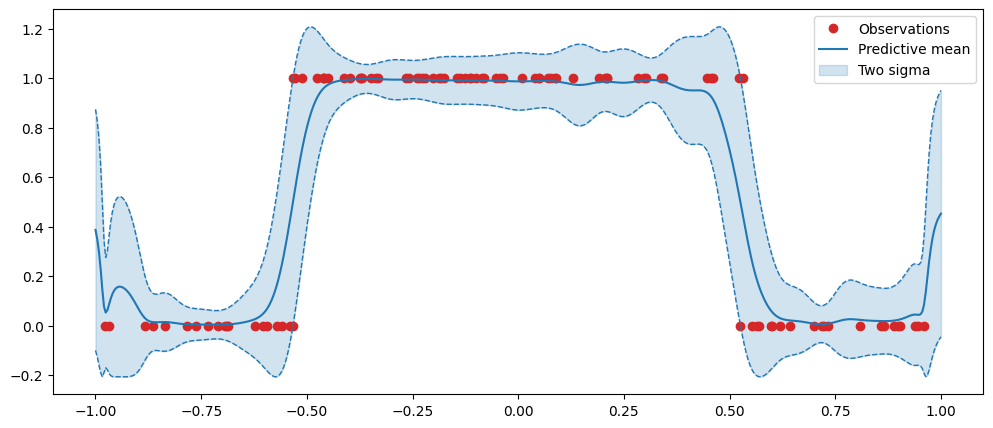

In [9]:
laplace_latent_dist = construct_laplace(xtest)
predictive_dist = likelihood(map_estimate, laplace_latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.legend()

However, the Laplace approximation is still limited by considering information about the posterior at a single location. On the other hand, through approximate sampling, MCMC methods allow us to learn all information about the posterior distribution.

## MCMC inference

At the high level, an MCMC sampler works by starting at an initial position and drawing a sample from a cheap-to-simulate distribution known as the _proposal_. The next step is to determine whether this sample could be considered a draw from the posterior. We accomplish this using an _acceptance probability_ determined via the sampler's _transition kernel_ which depends on the current position and the unnormalised target posterior distribution. If the new sample is more _likely_, we accept it; otherwise, we reject it and stay in our current position. Repeating these steps results in a Markov chain (a random sequence that depends only on the last state) whose stationary distribution (the long-run empirical distribution of the states visited) is the posterior. For a gentle introduction, see the first chapter of [A Handbook of Markov Chain Monte Carlo](https://www.mcmchandbook.net/HandbookChapter1.pdf).

### MCMC through BlackJax

Rather than implementing a suite of MCMC samplers, GPJax relies on MCMC-specific libraries for sampling functionality. We focus on [BlackJax](https://github.com/blackjax-devs/blackjax/) in this notebook, which we recommend adopting for general applications. However, we also support TensorFlow Probability as demonstrated in the [TensorFlow Probability Integration notebook](https://gpjax.readthedocs.io/en/latest/nbs/tfp_integration.html).

We'll use the No U-Turn Sampler (NUTS) implementation given in BlackJax for sampling. For the interested reader, NUTS is a Hamiltonian Monte Carlo sampling scheme where the number of leapfrog integration steps is computed at each step of the change according to the NUTS algorithm. In general, samplers constructed under this framework are very efficient.

We begin by generating _sensible_ initial positions for our sampler before defining an inference loop and sampling 500 values from our Markov chain. In practice, drawing more samples will be necessary.

In [10]:
# Adapted from BlackJax's introduction notebook.
num_adapt = 500
num_samples = 500

params, trainables, bijectors = gpx.initialise(posterior, key).unpack()
mll = posterior.marginal_log_likelihood(D, negative=False)
unconstrained_mll = jax.jit(lambda params: mll(gpx.constrain(params, bijectors)))

adapt = blackjax.window_adaptation(
    blackjax.nuts, unconstrained_mll, num_adapt, target_acceptance_rate=0.65
)

# Initialise the chain
unconstrained_params = gpx.unconstrain(params, bijectors)
last_state, kernel, _ = adapt.run(key, unconstrained_params)


def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos


# Sample from the posterior distribution
states, infos = inference_loop(key, kernel, last_state, num_samples)

### Sampler efficiency

BlackJax gives us easy access to our sampler's efficiency through metrics such as the sampler's _acceptance probability_ (the number of times that our chain accepted a proposed sample, divided by the total number of steps run by the chain). For NUTS and Hamiltonian Monte Carlo sampling, we typically seek an acceptance rate of 60-70% to strike the right balance between having a chain which is _stuck_ and rarely moves versus a chain that is too jumpy with frequent small steps.

In [11]:
acceptance_rate = jnp.mean(infos.acceptance_probability)
print(f"Acceptance rate: {acceptance_rate:.2f}")

Acceptance rate: 0.82


Our acceptance rate is slightly too large, prompting an examination of the chain's trace plots. A well-mixing chain will have very few (if any) flat spots in its trace plot whilst also not having too many steps in the same direction. In addition to the model's hyperparameters, there will be 500 samples for each of the 100 latent function values in the `states.position` dictionary. We depict the chains that correspond to the model hyperparameters and the first value of the latent function for brevity.

Text(0.5, 1.0, 'Latent Function (index = 1)')

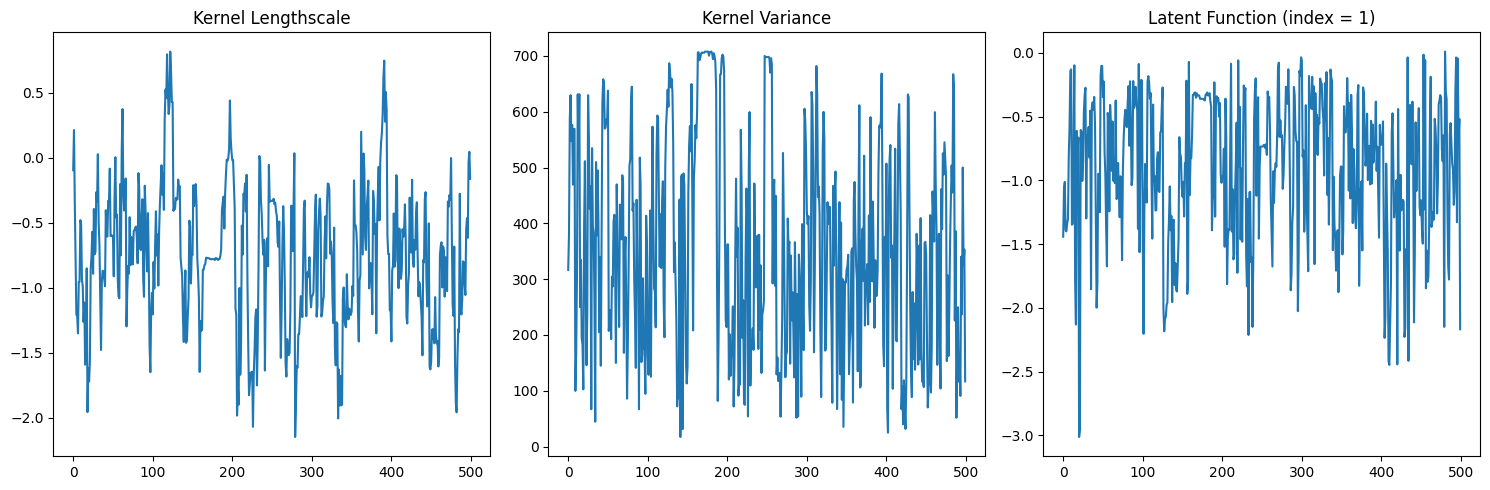

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
ax0.plot(states.position["kernel"]["lengthscale"])
ax1.plot(states.position["kernel"]["variance"])
ax2.plot(states.position["latent"][:, 0, :])
ax0.set_title("Kernel Lengthscale")
ax1.set_title("Kernel Variance")
ax2.set_title("Latent Function (index = 1)")

## Prediction

Having obtained samples from the posterior, we draw ten instances from our model's predictive distribution per MCMC sample. Using these draws, we will be able to compute credible values and expected values under our posterior distribution.

An ideal Markov chain would have samples completely uncorrelated with their neighbours after a single lag. However, in practice, correlations often exist within our chain's sample set. A commonly used technique to try and reduce this correlation is _thinning_ whereby we select every $n$th sample where $n$ is the minimum lag length at which we believe the samples are uncorrelated. Although further analysis of the chain's autocorrelation is required to find appropriate thinning factors, we employ a thin factor of 10 for demonstration purposes.

In [13]:
thin_factor = 10
samples = []

for i in range(0, num_samples, thin_factor):
    ps = gpx.parameters.copy_dict_structure(params)
    ps["kernel"]["lengthscale"] = states.position["kernel"]["lengthscale"][i]
    ps["kernel"]["variance"] = states.position["kernel"]["variance"][i]
    ps["latent"] = states.position["latent"][i, :, :]
    ps = gpx.constrain(ps, bijectors)

    latent_dist = posterior(ps, D)(xtest)
    predictive_dist = likelihood(ps, latent_dist)
    samples.append(predictive_dist.sample(seed=key, sample_shape=(10,)))

samples = jnp.vstack(samples)

lower_ci, upper_ci = jnp.percentile(samples, jnp.array([2.5, 97.5]), axis=0)
expected_val = jnp.mean(samples, axis=0)


Finally, we end this tutorial by plotting the predictions obtained from our model against the observed data.

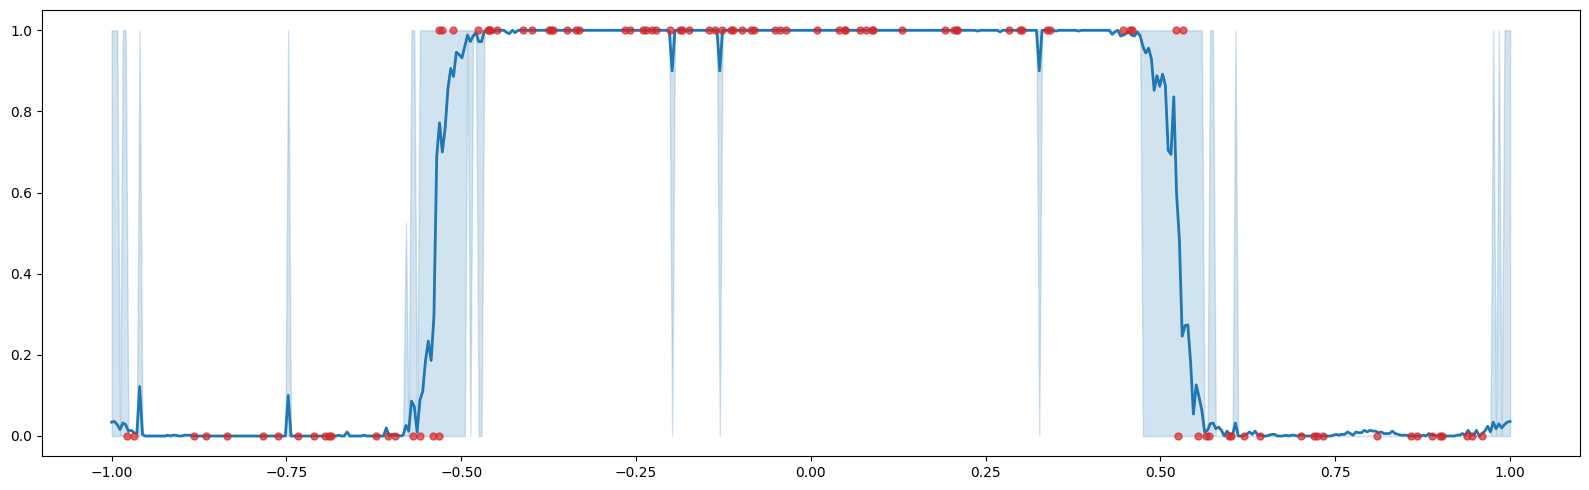

In [14]:
fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
ax.plot(
    x, y, "o", markersize=5, color="tab:red", label="Observations", zorder=2, alpha=0.7
)
ax.plot(
    xtest, expected_val, linewidth=2, color="tab:blue", label="Predicted mean", zorder=1
)
ax.fill_between(
    xtest.flatten(),
    lower_ci.flatten(),
    upper_ci.flatten(),
    alpha=0.2,
    color="tab:blue",
    label="95% CI",
)

## System configuration

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder & Daniel Dodd"

Author: Thomas Pinder & Daniel Dodd

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

optax     : 0.1.4
matplotlib: 3.3.3
blackjax  : 0.9.6
jax       : 0.4.1
gpjax     : 0.5.8
jaxkern   : 0.0.4
distrax   : 0.1.2

Watermark: 2.3.1

